# Medical Image Segmentation
This is a notebook aiming to generate masks for medical images to highlight specific structures or abnormalities base on the ["A02025-Medical-Image-Segmentation" kaggle competition](https://www.kaggle.com/competitions/a0-2025-medical-image-segmentation/overview). Here we are using a U-net architecture implemented using PyTorch.

## Table of Contents

- [1 - Packages](#1)
- [2 - Import and Visualize Data](#2)
- [3 - Prepare Data for Unet](#3)
- [4 - Define Model](#4)
- [5 - Train Model](#5)
- [6 - Evaluate Test Set](#6)
- [7 - Prepare Test Predictions fo Submission](#7)

<a name='1'></a>
## 1 - Packages

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
from scipy import stats
import torch.optim as optim
from tqdm import tqdm
import random
from skimage import measure, morphology
from scipy.ndimage import binary_fill_holes

<a name='2'></a>
## 2 - Import and Visualize Data

Creating `CTDataset` class to efficiently load both data and masks and apply transformations (e.g., normalization, resizing). Metadata is also included if a transformation is applied to allow inverse transform.

In [8]:
class CTDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform: #If transform is applied, want to keep meta data. Will allow eventual inverse for submission data.
            image, mask, metadata = self.transform(image, mask)
            return image, mask, metadata
        else:
            return image, mask


`visualize_dataset` helps to look at a few images and masks as a sanity check

In [12]:
def visualize_dataset(dataset, num_samples=5):
    images = []
    masks = []

    for i in range(num_samples):
        sample = dataset[i]

        # Handle optional metadata
        if len(sample) == 3:
            image, mask, _ = sample
        else:
            image, mask = sample

        # Convert image to numpy
        if isinstance(image, torch.Tensor):
            img_np = image.permute(1, 2, 0).numpy()
            img_np = np.clip(img_np, 0, 1)
        else:
            img_np = np.array(image)

        # Convert mask to numpy
        if isinstance(mask, torch.Tensor):
            mask_np = mask.squeeze().numpy()
        else:
            mask_np = np.array(mask)

        images.append(img_np)
        masks.append(mask_np)

    # Plot first few images with masks underneath
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))

    for i in range(num_samples):
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f"Image {i}")
        axes[0, i].axis("off")

        axes[1, i].imshow(masks[i], cmap="gray")
        axes[1, i].set_title(f"Mask {i}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

Load `dataset_raw` without any transformations to explore raw data. Want to make best decision on how to transform data for consistent input into Unet. Also want to confirm masks correspond to correct images

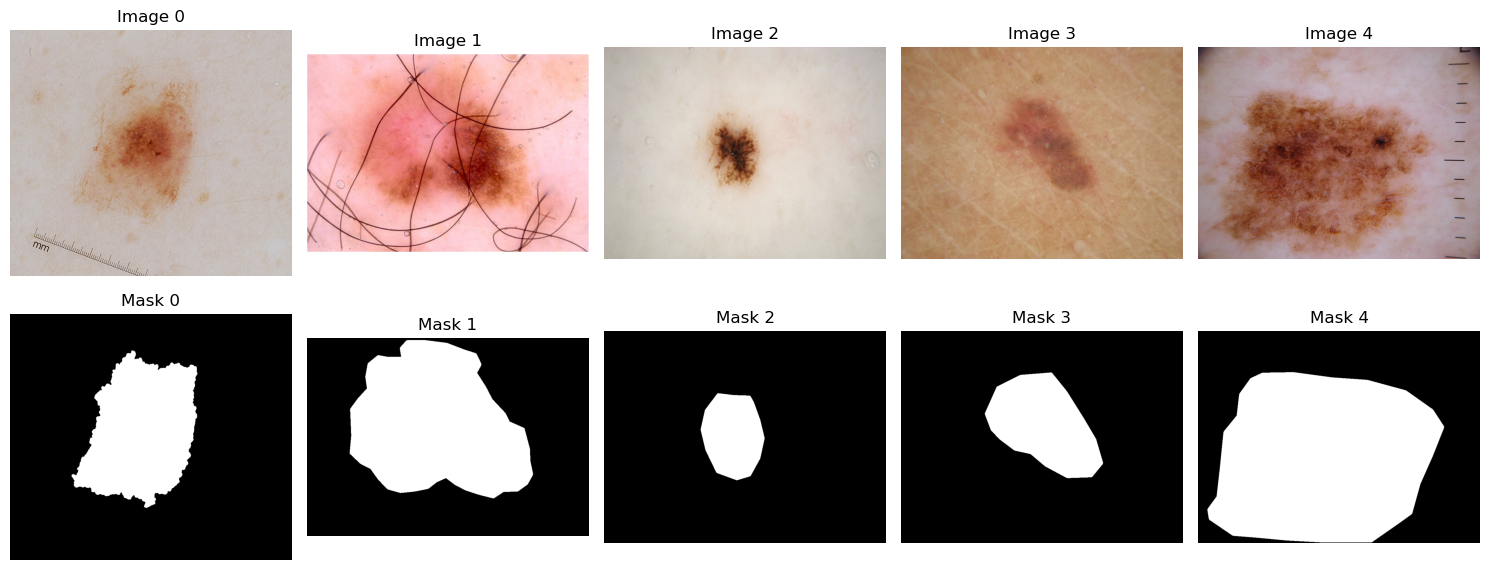

In [15]:
image_dir = 'Dataset/Train/Image'
mask_dir = 'Dataset/Train/Mask'

dataset_raw = CTDataset(image_dir=image_dir, mask_dir=mask_dir)
visualize_dataset(dataset_raw, num_samples=5)

Dimensions of the images are not consistent. Want to know the most common sizes and aspect ratio

In [18]:
widths, heights = [], []

for path in dataset_raw.image_paths:
    with Image.open(path) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

widths = np.array(widths)
heights = np.array(heights)
ratios = heights / widths

mode_ratio = stats.mode(ratios, keepdims=True)
mode_width = stats.mode(widths, keepdims=True)


print(f"Mode ratio: {mode_ratio.mode[0]} (fraction of data: {mode_ratio.count[0]/len(dataset_raw)})")
print(f"Mode width: {mode_width.mode[0]} (fraction of data: {mode_width.count[0]/len(dataset_raw)})")

Mode ratio: 0.75 (fraction of data: 0.6209751609935602)
Mode width: 1024 (fraction of data: 0.5234590616375345)


<a name='3'></a>
## 3 - Prepare Data for Unet

`ResizeAndPad` reduces each image's largest dimension to `target_size` and then pads the rest to make a square image. `TF.to_Tensor` also rescales pixels to 0-1 instead of 0-255, effectively normalizing input data. 

In [22]:
class ResizeAndPad:
    def __init__(self, target_size=256):
        self.target_size = target_size

    def __call__(self, image, mask):
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        original_size = image.shape[1:]  # (Height, Width)
        orig_h, orig_w = original_size

        # Compute scaling factor to match largest dimension to target_size
        scale = self.target_size / max(orig_h, orig_w)
        new_h = int(orig_h * scale)
        new_w = int(orig_w * scale)

        # Resize
        image = TF.resize(image, (new_h, new_w), interpolation=TF.InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (new_h, new_w), interpolation=TF.InterpolationMode.NEAREST)

        # Compute padding
        pad_h = self.target_size - new_h
        pad_w = self.target_size - new_w
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        image = TF.pad(image, (pad_left, pad_top, pad_right, pad_bottom), fill=0)
        mask = TF.pad(mask, (pad_left, pad_top, pad_right, pad_bottom), fill=0)

        # Clamp to ensure valid pixel range
        image = torch.clamp(image, 0, 1)
        mask = torch.clamp(mask, 0, 1)

        # Metadata for reversing the transform
        metadata = {
            "original_size": (orig_w, orig_h),  # (W, H) to match PIL and inverse_transform
            "new_size": (new_w, new_h),         # (W, H)
            "pad": (pad_top, pad_bottom, pad_left, pad_right),
            "scale": scale
        }

        return image, mask, metadata

Define Data Augmentation `Augment` to included random vertical/horizontal flips and random rotations (or none) for each epoch

In [24]:
class Augment:
    def __init__(self):
        pass

    def __call__(self, image, mask, apply_rotation=True):
        # Random horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random rotation by 90 degrees (only if enabled)
        if apply_rotation and random.random() > 0.5:
            angle = random.choice([90, 180, 270])
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        return image, mask

Want to apply `Augment` and `ResizeAndPad` to training set, but only `ResizeAndPad` to dev set.

In [26]:
# Apply ResizeAndPad + augmentation to training data
class TrainTransform:
    def __init__(self, target_size=256):
        self.resizer = ResizeAndPad(target_size=target_size)
        self.augment = Augment()

    def __call__(self, image, mask):
        # Apply flip augmentations before resizing
        image, mask = self.augment(image, mask, apply_rotation=False)
        image, mask, metadata = self.resizer(image, mask)

        # Apply rotation *after* resizing/padding
        if random.random() > 0.5:
            angle = random.choice([90, 180, 270])
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        return image, mask, metadata

# No augmentation for dev data
class EvalTransform:
    def __init__(self, target_size=256):
        self.resizer = ResizeAndPad(target_size=target_size)

    def __call__(self, image, mask):
        return self.resizer(image, mask)


Import and split data into training/dev sets (here using 90/10 split)

In [28]:
# Create raw dataset to determine length
raw_dataset = CTDataset(image_dir=image_dir, mask_dir=mask_dir)

# Split data
indices = np.arange(len(raw_dataset))
np.random.seed(42)
np.random.shuffle(indices)

split = int(0.9 * len(raw_dataset))
train_idx, dev_idx = indices[:split], indices[split:]

# Assign transforms for train/dev sets
target_size=256
train_transform = TrainTransform(target_size=target_size)
eval_transform = EvalTransform(target_size=target_size)

train_dataset = Subset(CTDataset(image_dir=image_dir, mask_dir=mask_dir, transform=train_transform), train_idx)
dev_dataset = Subset(CTDataset(image_dir=image_dir, mask_dir=mask_dir, transform=eval_transform), dev_idx)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False)

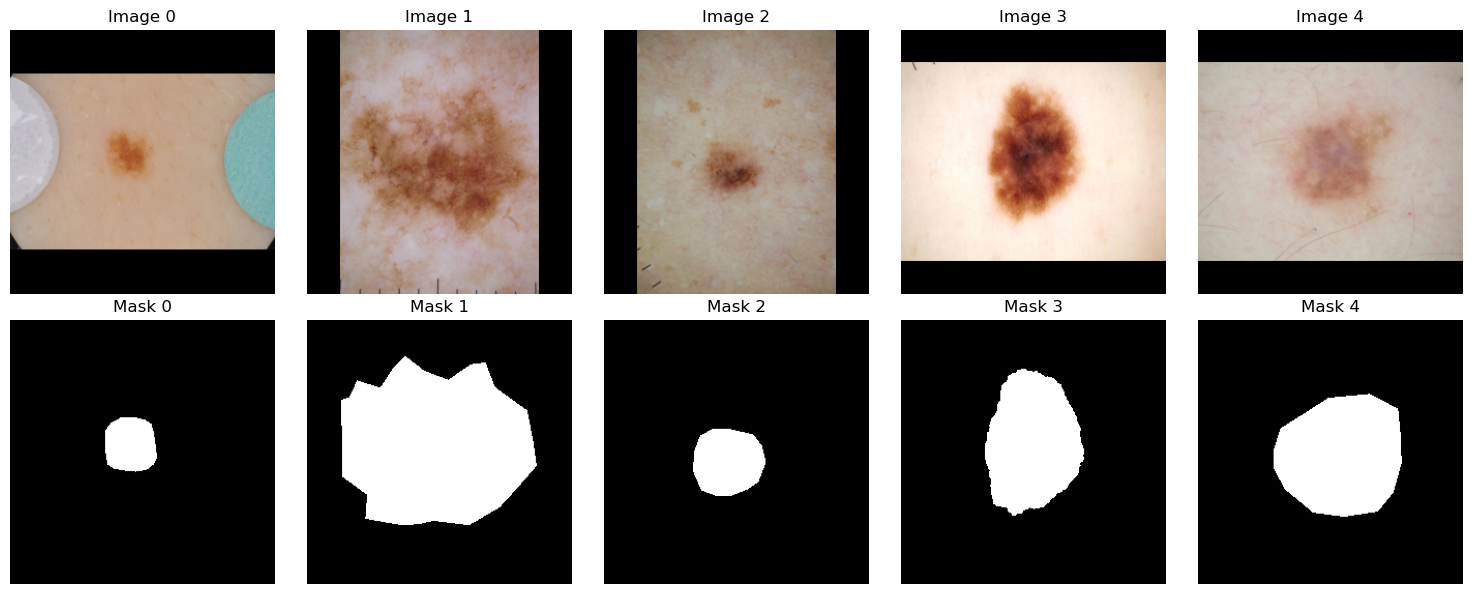

In [30]:
# Visualize first 5 samples in the dataset
visualize_dataset(train_dataset, num_samples=5)

<a name='4'></a>
## 4 - Define Model

In [32]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout > 0:
            layers.append(nn.Dropout2d(p=dropout))
        layers += [
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if dropout > 0:
            layers.append(nn.Dropout2d(p=dropout))
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024, dropout=0.3)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512, dropout=0.2)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))
        bn = self.bottleneck(self.pool4(d4))

        u4 = self.up4(bn)
        u4 = torch.cat([u4, d4], dim=1)
        u4 = self.conv4(u4)

        u3 = self.up3(u4)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)

        return self.final(u1)  # Output shape: (B, 1, 256, 256)


Use DICE and binary cross-entropy for loss (not just pure DICE).

In [35]:
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6, alpha=0.5):
        super().__init__()
        self.dice = DiceLoss(smooth)
        self.bce = nn.BCEWithLogitsLoss()
        self.alpha = alpha  # weight between losses

    def forward(self, preds, targets):
        bce_loss = self.bce(preds, targets)
        dice_loss = self.dice(preds, targets)
        combined = self.alpha * bce_loss + (1 - self.alpha) * dice_loss
        return combined, bce_loss.item(), dice_loss.item()


Also define DiceLoss to use as benchmark

In [38]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # convert logits to probs
        preds = preds.view(-1)
        targets = targets.view(-1)

        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice


Define evaluation function for dev set

In [40]:
def evaluate_model(model, dataloader, device, save_images=False, epoch=0):
    model.eval()
    dice_scores = []

    save_dir = f"val_outputs/epoch_{epoch}"
    if save_images:
        os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for i, (images, masks, *_ ) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds_bin = (preds > 0.5).float()

            intersection = (preds_bin * masks).sum(dim=(1,2,3))
            union = preds_bin.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3))
            dice = (2 * intersection + 1e-6) / (union + 1e-6)
            dice_scores.extend(dice.cpu().numpy())

            # Save visualizations
            if save_images and i < 5:  # Save first 5 batches
                for j in range(images.shape[0]):
                    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
                    axes[0].imshow(images[j].cpu().permute(1, 2, 0))
                    axes[0].set_title("Image")
                    axes[1].imshow(masks[j].cpu().squeeze(), cmap="gray")
                    axes[1].set_title("Ground Truth")
                    axes[2].imshow(preds_bin[j].cpu().squeeze(), cmap="gray")
                    axes[2].set_title("Prediction")
                    for ax in axes:
                        ax.axis("off")
                    fig.savefig(os.path.join(save_dir, f"sample_{i}_{j}.png"))
                    plt.close(fig)

    mean_dice = sum(dice_scores) / len(dice_scores)
    print(f"Dev Dice Score: {mean_dice:.4f}")
    return mean_dice

Define training loop. Keep track of history to monitor DICE loss, BCE loss, combined training loss, and DICE score versus epoch number

In [43]:
def train_model(model, train_loader, dev_loader, device, num_epochs=10):
    model = model.to(device)
    criterion = DiceBCELoss(alpha=0.5)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    history = {
        'epoch': [],
        'train_loss': [],
        'bce_loss': [],
        'dice_loss': [],
        'val_dice': []
    }

    best_dice = 0.0  # Track best validation score
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_bce = 0
        total_dice = 0

        for images, masks, *_ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss, bce, dice = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_bce += bce
            total_dice += dice
        
        avg_train_loss = total_loss / len(train_loader)
        avg_bce_loss = total_bce / len(train_loader)
        avg_dice_loss = total_dice / len(train_loader)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, BCE: {avg_bce_loss:.4f}, Dice: {avg_dice_loss:.4f}")
        
        val_dice = evaluate_model(model, dev_loader, device, save_images=True, epoch=epoch)

        history['epoch'].append(epoch + 1)
        history['train_loss'].append(avg_train_loss)
        history['bce_loss'].append(avg_bce_loss)
        history['dice_loss'].append(avg_dice_loss)
        history['val_dice'].append(val_dice)

        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), "best_unet_model.pth")
            print(f"Model saved with Dice score: {val_dice:.4f}")
    
    return history

`plot_training_history` provides visualization for training history

In [45]:
def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    # Losses
    plt.subplot(1, 3, 1)
    plt.plot(history['epoch'], history['train_loss'], label='Total Loss')
    plt.plot(history['epoch'], history['bce_loss'], label='BCE Loss', linestyle='--')
    plt.plot(history['epoch'], history['dice_loss'], label='Dice Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Components')
    plt.grid(True)
    plt.legend()

    # Validation Dice
    plt.subplot(1, 3, 2)
    plt.plot(history['epoch'], history['val_dice'], label='Validation Dice', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Validation Dice over Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

<a name='5'></a>
## 5 - Train Model

In [48]:
model = UNet(in_channels=3, out_channels=1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

history = train_model(model, train_loader, dev_loader, device=device, num_epochs=30)

Epoch 1/30: 100%|█████████████████████████████| 123/123 [50:54<00:00, 24.83s/it]


Epoch 1, Train Loss: 0.4156, BCE: 0.3748, Dice: 0.4563
Dev Dice Score: 0.8305
Model saved with Dice score: 0.8305


Epoch 2/30: 100%|█████████████████████████████| 123/123 [49:52<00:00, 24.33s/it]


Epoch 2, Train Loss: 0.3265, BCE: 0.2756, Dice: 0.3774
Dev Dice Score: 0.8034


Epoch 3/30: 100%|█████████████████████████████| 123/123 [48:46<00:00, 23.79s/it]


Epoch 3, Train Loss: 0.2851, BCE: 0.2325, Dice: 0.3376
Dev Dice Score: 0.8331
Model saved with Dice score: 0.8331


Epoch 4/30: 100%|█████████████████████████████| 123/123 [48:43<00:00, 23.77s/it]


Epoch 4, Train Loss: 0.2550, BCE: 0.2096, Dice: 0.3005
Dev Dice Score: 0.8170


Epoch 5/30: 100%|█████████████████████████████| 123/123 [58:29<00:00, 28.54s/it]


Epoch 5, Train Loss: 0.2284, BCE: 0.1869, Dice: 0.2699
Dev Dice Score: 0.8482
Model saved with Dice score: 0.8482


Epoch 6/30: 100%|█████████████████████████████| 123/123 [51:39<00:00, 25.20s/it]


Epoch 6, Train Loss: 0.2144, BCE: 0.1761, Dice: 0.2526
Dev Dice Score: 0.8503
Model saved with Dice score: 0.8503


Epoch 7/30: 100%|█████████████████████████████| 123/123 [53:29<00:00, 26.09s/it]


Epoch 7, Train Loss: 0.1912, BCE: 0.1582, Dice: 0.2241
Dev Dice Score: 0.8667
Model saved with Dice score: 0.8667


Epoch 8/30: 100%|█████████████████████████████| 123/123 [54:02<00:00, 26.36s/it]


Epoch 8, Train Loss: 0.1817, BCE: 0.1505, Dice: 0.2128
Dev Dice Score: 0.8067


Epoch 9/30: 100%|█████████████████████████████| 123/123 [52:47<00:00, 25.75s/it]


Epoch 9, Train Loss: 0.1707, BCE: 0.1450, Dice: 0.1963
Dev Dice Score: 0.8854
Model saved with Dice score: 0.8854


Epoch 10/30: 100%|████████████████████████████| 123/123 [48:22<00:00, 23.59s/it]


Epoch 10, Train Loss: 0.1604, BCE: 0.1373, Dice: 0.1836
Dev Dice Score: 0.8834


Epoch 11/30: 100%|████████████████████████████| 123/123 [49:08<00:00, 23.97s/it]


Epoch 11, Train Loss: 0.1485, BCE: 0.1273, Dice: 0.1698
Dev Dice Score: 0.8689


Epoch 12/30: 100%|████████████████████████████| 123/123 [51:06<00:00, 24.93s/it]


Epoch 12, Train Loss: 0.1495, BCE: 0.1301, Dice: 0.1689
Dev Dice Score: 0.8673


Epoch 13/30: 100%|████████████████████████████| 123/123 [52:12<00:00, 25.46s/it]


Epoch 13, Train Loss: 0.1398, BCE: 0.1229, Dice: 0.1568
Dev Dice Score: 0.8800


Epoch 14/30: 100%|████████████████████████████| 123/123 [50:23<00:00, 24.58s/it]


Epoch 14, Train Loss: 0.1428, BCE: 0.1265, Dice: 0.1591
Dev Dice Score: 0.8683


Epoch 15/30: 100%|████████████████████████████| 123/123 [49:11<00:00, 24.00s/it]


Epoch 15, Train Loss: 0.1316, BCE: 0.1164, Dice: 0.1468
Dev Dice Score: 0.8829


Epoch 16/30: 100%|████████████████████████████| 123/123 [48:25<00:00, 23.62s/it]


Epoch 16, Train Loss: 0.1270, BCE: 0.1136, Dice: 0.1404
Dev Dice Score: 0.8736


Epoch 17/30: 100%|████████████████████████████| 123/123 [49:21<00:00, 24.08s/it]


Epoch 17, Train Loss: 0.1305, BCE: 0.1179, Dice: 0.1431
Dev Dice Score: 0.8969
Model saved with Dice score: 0.8969


Epoch 18/30: 100%|████████████████████████████| 123/123 [51:01<00:00, 24.89s/it]


Epoch 18, Train Loss: 0.1269, BCE: 0.1139, Dice: 0.1399
Dev Dice Score: 0.9007
Model saved with Dice score: 0.9007


Epoch 19/30: 100%|████████████████████████████| 123/123 [49:31<00:00, 24.16s/it]


Epoch 19, Train Loss: 0.1255, BCE: 0.1191, Dice: 0.1319
Dev Dice Score: 0.8886


Epoch 20/30: 100%|████████████████████████████| 123/123 [49:19<00:00, 24.06s/it]


Epoch 20, Train Loss: 0.1305, BCE: 0.1203, Dice: 0.1407
Dev Dice Score: 0.8890


Epoch 21/30: 100%|████████████████████████████| 123/123 [48:01<00:00, 23.43s/it]


Epoch 21, Train Loss: 0.1156, BCE: 0.1066, Dice: 0.1246
Dev Dice Score: 0.8812


Epoch 22/30: 100%|████████████████████████████| 123/123 [49:14<00:00, 24.02s/it]


Epoch 22, Train Loss: 0.1104, BCE: 0.1022, Dice: 0.1187
Dev Dice Score: 0.8777


Epoch 23/30: 100%|████████████████████████████| 123/123 [48:57<00:00, 23.88s/it]


Epoch 23, Train Loss: 0.1154, BCE: 0.1047, Dice: 0.1260
Dev Dice Score: 0.8745


Epoch 24/30: 100%|████████████████████████████| 123/123 [48:53<00:00, 23.85s/it]


Epoch 24, Train Loss: 0.1189, BCE: 0.1107, Dice: 0.1270
Dev Dice Score: 0.9002


Epoch 25/30: 100%|████████████████████████████| 123/123 [50:01<00:00, 24.40s/it]


Epoch 25, Train Loss: 0.1137, BCE: 0.1062, Dice: 0.1211
Dev Dice Score: 0.8749


Epoch 26/30: 100%|████████████████████████████| 123/123 [48:06<00:00, 23.47s/it]


Epoch 26, Train Loss: 0.1112, BCE: 0.1020, Dice: 0.1205
Dev Dice Score: 0.8758


Epoch 27/30: 100%|████████████████████████████| 123/123 [51:01<00:00, 24.89s/it]


Epoch 27, Train Loss: 0.1066, BCE: 0.0978, Dice: 0.1154
Dev Dice Score: 0.9004


Epoch 28/30: 100%|████████████████████████████| 123/123 [51:07<00:00, 24.94s/it]


Epoch 28, Train Loss: 0.1084, BCE: 0.1006, Dice: 0.1163
Dev Dice Score: 0.8988


Epoch 29/30: 100%|████████████████████████████| 123/123 [55:39<00:00, 27.15s/it]


Epoch 29, Train Loss: 0.1044, BCE: 0.0975, Dice: 0.1114
Dev Dice Score: 0.8794


Epoch 30/30: 100%|████████████████████████████| 123/123 [57:41<00:00, 28.14s/it]


Epoch 30, Train Loss: 0.1118, BCE: 0.1044, Dice: 0.1192
Dev Dice Score: 0.8950


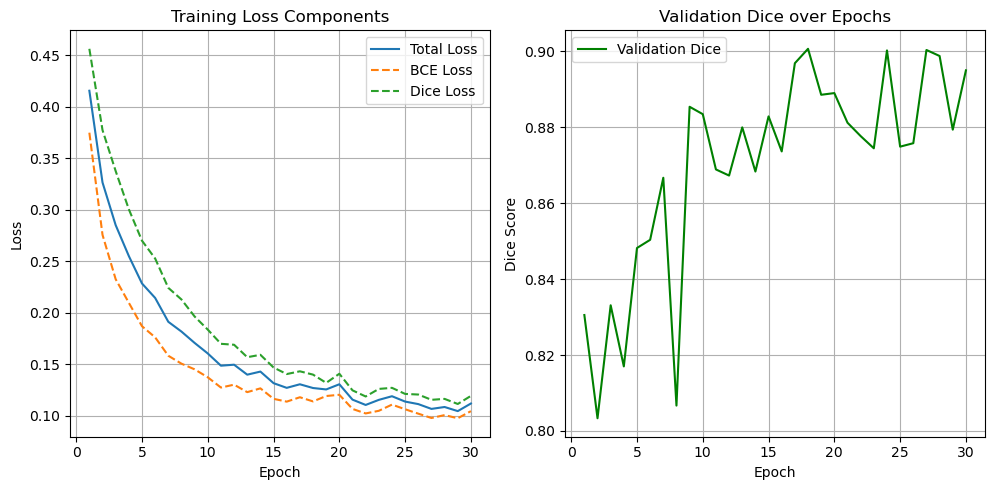

In [85]:
#Visualize and export history
plot_training_history(history)
df_history = pd.DataFrame(history)
df_history.to_csv('TrainingHistory.csv', index=False)

Apply postprocessing to fill holes keep the largest connected region in each mask. This ultimately had a marginal and sometimes negative effect on the overall DICE score, and so was not included in the final submission.

In [53]:
def fill_holes(mask):
    return binary_fill_holes(mask).astype("uint8")

def keep_largest_connected_component(mask):
    labeled = measure.label(mask)
    regions = measure.regionprops(labeled)
    if not regions:
        return mask
    largest = max(regions, key=lambda x: x.area)
    cleaned = (labeled == largest.label).astype("uint8")
    return cleaned

def postprocess_mask(mask):
    mask = fill_holes(mask)
    mask = keep_largest_connected_component(mask)
    return mask

In [55]:
def evaluate_with_postprocessing(model, dev_loader, device):
    model.eval()
    dice_scores = []

    with torch.no_grad():
        for images, masks, *_ in dev_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().cpu().numpy()
            masks = masks.cpu().numpy()

            for pred, true in zip(preds, masks):
                pred = pred.squeeze().astype("uint8")
                true = true.squeeze().astype("uint8")

                post_pred = postprocess_mask(pred)
                post_pred = (post_pred > 0).astype("float32")

                intersection = (post_pred * true).sum()
                dice = (2. * intersection + 1e-6) / (post_pred.sum() + true.sum() + 1e-6)
                dice_scores.append(dice)

    print(f"Postprocessed Validation Dice: {np.mean(dice_scores):.4f}")
    return dice_scores


In [57]:
model.load_state_dict(torch.load("best_unet_model.pth", map_location=device))
model.to(device)

post_dice_scores = evaluate_with_postprocessing(model, dev_loader, device)

Postprocessed Validation Dice: 0.8993


<a name='6'></a>
## 6 - Evaluate Test Set

In [59]:
#Define inverse transform of ResizeAndPad for test data to prepare for submission
def inverse_transform_mask(pred_mask, metadata):
    if isinstance(pred_mask, np.ndarray):
        pred_mask = Image.fromarray(pred_mask.astype(np.uint8))

    orig_w, orig_h = metadata["original_size"]
    target_w, target_h = pred_mask.size 

    # Scale based on height and width
    scale = min(target_w / orig_w, target_h / orig_h)
    new_w, new_h = int(orig_w * scale), int(orig_h * scale)

    # Compute cropping area (center crop to remove padding)
    left = (target_w - new_w) // 2
    top = (target_h - new_h) // 2
    cropped_mask = pred_mask.crop((left, top, left + new_w, top + new_h))

    # Resize cropped mask to original size (W, H)
    final_mask = cropped_mask.resize((orig_w, orig_h), Image.NEAREST)
    return final_mask

In [68]:
# Load the saved model weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1)  # Ensure this matches model definition 
model.load_state_dict(torch.load("best_unet_model.pth", map_location=device))
model.to(device)
model.eval()

# Prepare test dataset
test_image_dir = "Dataset/Test/Image"
output_mask_dir = "PredictedMasks"
os.makedirs(output_mask_dir, exist_ok=True)

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".jpg")])
transform = ResizeAndPad()

for img_path in tqdm(test_image_paths, desc="Generating predictions"):
    image = Image.open(img_path).convert("RGB")
    
    # Apply transform and extract only the image tensor. Include metadata for inverse transform
    image_tensor, _, metadata = transform(image, image)  # dummy mask input
    input_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        output_mask = torch.sigmoid(output).squeeze().cpu().numpy()

    # Step 1: Binarize
    output_mask_bin = (output_mask > 0.5).astype("uint8")

    # Step 2: Postprocess (fill holes, keep main region)
    output_mask_bin = postprocess_mask(output_mask_bin)

    # Step 3: Convert to PIL for inverse transform
    mask_image = Image.fromarray(output_mask_bin * 255).convert("L")

    # Step 4: Inverse transform to original image dimensions
    final_mask = inverse_transform_mask(mask_image, metadata)

    # Step 5: Save
    filename = os.path.basename(img_path).replace(".jpg", "_pred.png")
    final_mask.save(os.path.join(output_mask_dir, filename))


Generating predictions: 100%|█████████████████| 192/192 [04:31<00:00,  1.41s/it]


<a name='7'></a>
## 7 - Prepare Test Predictions fo Submission

In [71]:
def mask_to_rle(mask):
    """
    Convert binary mask to run-length encoding.
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))

def generate_submission_csv(predicted_dir, output_csv_path):
    """
    Generate a CSV file with RLE-encoded masks.

    Args:
        predicted_dir (str): Path to directory containing predicted binary mask images (.png).
        output_csv_path (str): File path to save the resulting CSV.
    """
    submission_data = []

    for filename in sorted(os.listdir(predicted_dir)):
        if filename.endswith(".png"):
            image_id = os.path.splitext(filename)[0].replace("_pred", "")
            mask = Image.open(os.path.join(predicted_dir, filename))
            mask_array = np.array(mask)
            binary_mask = (mask_array > 0).astype(np.uint8)
            rle = mask_to_rle(binary_mask)
            submission_data.append((image_id, rle))

    submission_df = pd.DataFrame(submission_data, columns=["ID", "Mask"])
    submission_df.to_csv(output_csv_path, index=False)
    print(f"Submission saved to: {output_csv_path}")

In [73]:
predicted_mask_dir = "PredictedMasks"
submission_csv_file = "submission.csv"

generate_submission_csv(predicted_mask_dir, submission_csv_file)

Submission saved to: submission.csv


(1) First submission uses U-Net based approach with four levels, simple resizing and padding to 256x256 for training data. No data augmentation was used for 10 epochs. Trained with Pure Dice Loss. DICE score for test data was 0.8376

(2) Second submission added Data Augmentation (flips and rotations) and postprocessing (fill holes, remove small disconnected regions). Model trained with 50/50 DICE and BCE loss for 10 epochs. DICE score for test data was 0.8635

(3) Same as (2) but trained longer (30 epochs). DICE score for test data was 0.8702

(4) Same as (3) but removed postprocessing step. DICE score for test data was 0.8635